# Deployment: a trading strategy
> **Warning!** Please run `01_cleaning.ipynb` and `03_prediction.ipynb` first if you haven't already

In [771]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functions.constants import BM_NAME, STARTDATE, ENDDATE, N_THRESHOLD_BPS, DATA_DIR, EVAL_START_DATE, TEST_START_DATE  # noqa: F401

from functions.helper_fns import featurize_time_series,load_active_returns,evaluate_model_performance,get_X_and_y_values  # noqa: F401
import seaborn as sns

In [772]:
chosen_period = "1w"
optimum_model_name = "Stacking"
eval_dataset_mode = False

predictions_path = f"{DATA_DIR}/{BM_NAME}_eval_predictions_{optimum_model_name}.csv" if eval_dataset_mode else f"{DATA_DIR}/{BM_NAME}_{chosen_period}_outperformance_predictions_{optimum_model_name}.csv"
predictions = pd.read_csv(predictions_path,parse_dates=["Date"])
predictions

,Date,Ticker,outperform_1w_actual,outperform_1w_predicted,outperform_1w_probability
0,2015-03-30,A UN,0,0,0.450140
1,2015-04-06,A UN,1,0,0.455896
2,2015-04-13,A UN,1,1,0.511808
3,2015-04-20,A UN,0,0,0.475626
4,2015-04-27,A UN,0,0,0.452040
...,...,...,...,...,...
249986,2024-09-02,ZTS UN,0,1,0.542104
249987,2024-09-09,ZTS UN,1,1,0.539274
249988,2024-09-16,ZTS UN,1,1,0.518022
249989,2024-09-23,ZTS UN,0,1,0.543103


In [773]:
if eval_dataset_mode:
    predictions_test = predictions
else:
    predictions_train_and_eval = predictions[predictions.Date < TEST_START_DATE] #not spectacularly useful but good for debugging
    predictions_test = predictions[predictions.Date >= TEST_START_DATE]
    predictions_test
(predictions_test.head())

,Date,Ticker,outperform_1w_actual,outperform_1w_predicted,outperform_1w_probability
203715,2023-01-02,A UN,0,0,0.474096
203716,2023-01-09,A UN,0,0,0.484353
203717,2023-01-16,A UN,0,0,0.434521
203718,2023-01-23,A UN,0,0,0.433683
203719,2023-01-30,A UN,0,0,0.454063


### Load prices by ticker and by BM

In [774]:
# Load data
bm_index_prices_df_path = DATA_DIR + BM_NAME + "_BM_prices.csv"
bm_holdings_prices_df_path = DATA_DIR + BM_NAME + "_constituents_prices.csv"

def load_bm_index_df(path):
    df = pd.read_csv(path, skiprows=3)
    df = df.rename(columns={df.columns[0]: "Date"})
    df = df[2:]
    #ensure all cols except Date are numeric. Coerce nan if not
    for col in df.columns[1:]:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df["Date"] = pd.to_datetime(df["Date"])
    return df

bm_index_prices_raw = load_bm_index_df(bm_index_prices_df_path)
bm_holdings_prices_raw = load_bm_index_df(bm_holdings_prices_df_path)

/var/folders/7n/wd610q_96_5crpp9w0bq0gfh0000gn/T/ipykernel_6873/2162835386.py:6: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,

In [775]:
def remove_BBG_suffixes(df):
    """
    Remove the suffixes " Equity" from the column names
    """
    df.columns = df.columns.str.replace(' Equity', '')
    # df.columns = df.columns.str.replace(' Index', '') #let's keep the SPX Index in for clarity
    return df

def melt_data(df):
    """
    Melt the dataframe to have a column for the date, a column for the ticker and a column for the price
    """
    df = df.melt(id_vars=["Date"], var_name="Ticker", value_name="Price")
    return df

def preprocess_and_clean_data(df):
    df = remove_BBG_suffixes(df)
    df = melt_data(df)
    return df

bm_index_prices = preprocess_and_clean_data(bm_index_prices_raw)
bm_holdings_prices = preprocess_and_clean_data(bm_holdings_prices_raw)

In [776]:
# pricing_date = predictions_test.Date.iloc[0]
portfolio_df_array = []
unique_dates = predictions_test.Date.unique()
for pricing_date in unique_dates:
    this_date_predictions = predictions_test[predictions_test.Date == pricing_date]
    outperform_prob_column = f"outperform_{chosen_period}_probability"
    # print("This date predictions df") 
    # print(this_date_predictions.head())
    this_date_prices = bm_holdings_prices[bm_holdings_prices.Date == pricing_date]
    #if this_date_prices is empty, use proxy_pricing_date = pricing_date - 1 biz day. Look back 5 days until we find a non-empty df
    if not len(this_date_prices):
        proxy_pricing_date = pricing_date
        lookback_days = 0
        lookback_window = 5
        while this_date_prices.empty:
            proxy_pricing_date = proxy_pricing_date - pd.Timedelta(days=1)
            this_date_prices = bm_holdings_prices[bm_holdings_prices.Date == proxy_pricing_date]
            lookback_days += 1
            if lookback_days > lookback_window:
                raise ValueError(f"Could not find a non-empty prices df in the last {lookback_window} days for {pricing_date}")
    this_date_prices = this_date_prices.drop(columns=["Date"])
    this_date_predictions = this_date_predictions.merge(this_date_prices, on="Ticker", how="left")
    #if prices are null for a ticker set the outperform probability to 0 and also outperform_1w_predicted etc to 0
    this_date_predictions[outperform_prob_column] = this_date_predictions[outperform_prob_column].where(this_date_predictions.Price.notnull(), 0)
    this_date_predictions[f"outperform_{chosen_period}_predicted"] = this_date_predictions[f"outperform_{chosen_period}_predicted"].where(this_date_predictions.Price.notnull(), 0)
    # top_N_outperformers = 20
    # top_N_cutoff = this_date_predictions[outperform_prob_column].nlargest(top_N_outperformers).iloc[-1]
    probability_cutoff = 0.50
    num_outperformers = this_date_predictions[outperform_prob_column].gt(probability_cutoff).sum()
    print(f"Pricing Date: {pricing_date}, outperformer count: {num_outperformers}")
    num_non_null_prices = this_date_predictions.Price.notnull().sum()
    if num_outperformers == 0:
        print(f"No outperformers forecasted on {pricing_date}")
    wt_per_outperformer = 1 / num_outperformers if num_outperformers > 0 else 1 / num_non_null_prices
    if num_outperformers > 0:
        this_date_predictions["decision_port_weight"] = this_date_predictions[outperform_prob_column].apply(lambda x: wt_per_outperformer if x > probability_cutoff else 0)
    else:
        #assign wt_per_outperformer to all with non-null prices
        this_date_predictions["decision_port_weight"] = this_date_predictions.Price.apply(lambda x: wt_per_outperformer if pd.notnull(x) else 0)
        # this_date_predictions["decision_port_weight"] = this_date_predictions[outperform_prob_column].apply(lambda x: wt_per_outperformer if x > probability_cutoff else 0)
    this_date_portfolio = this_date_predictions[["Date","Ticker","decision_port_weight","Price"]]
    # this_date_portfolio
    portfolio_df_array.append(this_date_portfolio)

Pricing Date: 2023-01-02T00:00:00.000000000, outperformer count: 174
Pricing Date: 2023-01-09T00:00:00.000000000, outperformer count: 130
Pricing Date: 2023-01-16T00:00:00.000000000, outperformer count: 156
Pricing Date: 2023-01-23T00:00:00.000000000, outperformer count: 159
Pricing Date: 2023-01-30T00:00:00.000000000, outperformer count: 208
Pricing Date: 2023-02-06T00:00:00.000000000, outperformer count: 183
Pricing Date: 2023-02-13T00:00:00.000000000, outperformer count: 163
Pricing Date: 2023-02-20T00:00:00.000000000, outperformer count: 198
Pricing Date: 2023-02-27T00:00:00.000000000, outperformer count: 141
Pricing Date: 2023-03-06T00:00:00.000000000, outperformer count: 188
Pricing Date: 2023-03-13T00:00:00.000000000, outperformer count: 132
Pricing Date: 2023-03-20T00:00:00.000000000, outperformer count: 170
Pricing Date: 2023-03-27T00:00:00.000000000, outperformer count: 193
Pricing Date: 2023-04-03T00:00:00.000000000, outperformer count: 217
Pricing Date: 2023-04-10T00:00:00.

In [777]:
proposed_buys_df = pd.concat(portfolio_df_array)
proposed_buys_df

,Date,Ticker,decision_port_weight,Price
0,2023-01-02,A UN,0.000000,149.65
1,2023-01-02,AAPL UW,0.005747,129.93
2,2023-01-02,ABBV UN,0.000000,161.61
3,2023-01-02,ABNB UW,0.005747,85.50
4,2023-01-02,ABT UN,0.000000,109.79
...,...,...,...,...
498,2024-09-30,XYL UN,0.000000,135.03
499,2024-09-30,YUM UN,0.000000,139.71
500,2024-09-30,ZBH UN,0.005405,107.95
501,2024-09-30,ZBRA UW,0.000000,370.32


In [778]:
#extend portfolio_df with 'last_date_port_weight' and 'last_date_price' columns
portfolio_df = pd.concat(portfolio_df_array)
trades_df_array = []

seed_capital = 1e6
#extend with last week's held weights and prices
# portfolio_df["last_date_port_weight"] = portfolio_df.groupby("Ticker")["decision_port_weight"].shift(1)
# portfolio_df["last_date_price"] = portfolio_df.groupby("Ticker")["Price"].shift(1)
# portfolio_df

#iterate by date
# for pricing_date in unique_dates:
pricing_date = unique_dates[0]
for pricing_date in unique_dates:
    this_period_portfolio = portfolio_df[portfolio_df.Date == pricing_date]
    #check if this is the first date (i.e. last_date_port_weight is null)
    is_first_date = pricing_date == min(unique_dates)
    if is_first_date:
        this_period_portfolio['shares_buying'] = seed_capital * this_period_portfolio.decision_port_weight / this_period_portfolio.Price
        this_period_portfolio['shares_selling'] = 0
        this_period_portfolio['cash_flow'] = -seed_capital * this_period_portfolio.decision_port_weight
    else:
        #get last period from unique_dates
        last_period = unique_dates[unique_dates < pricing_date].max()
        last_period_portfolio = trades_df_array[-1]
        this_period_portfolio['shares_selling'] = last_period_portfolio['shares_buying']
        revenue_from_selling = (last_period_portfolio['shares_buying'] * this_period_portfolio['Price']).sum()
        print(f"Revenue from selling as of {pricing_date}: ${revenue_from_selling.sum()}")
        this_period_portfolio['shares_buying'] = revenue_from_selling * this_period_portfolio.decision_port_weight / this_period_portfolio.Price
        this_period_portfolio['cash_flow'] = 0
    this_period_portfolio['value_at_close'] = this_period_portfolio['shares_buying'] * this_period_portfolio['Price']
    trades_df_array.append(this_period_portfolio)

Revenue from selling as of 2023-01-09T00:00:00.000000000: $1036659.8581572471
Revenue from selling as of 2023-01-16T00:00:00.000000000: $1076773.8302476327
Revenue from selling as of 2023-01-23T00:00:00.000000000: $1094844.2087205972
Revenue from selling as of 2023-01-30T00:00:00.000000000: $1096419.2590937791
Revenue from selling as of 2023-02-06T00:00:00.000000000: $1118636.537563822
Revenue from selling as of 2023-02-13T00:00:00.000000000: $1125408.3117057895
Revenue from selling as of 2023-02-20T00:00:00.000000000: $1110637.8291142406
Revenue from selling as of 2023-02-27T00:00:00.000000000: $1084990.4388859095
Revenue from selling as of 2023-03-06T00:00:00.000000000: $1095923.720594599
Revenue from selling as of 2023-03-13T00:00:00.000000000: $1026232.2590569961
Revenue from selling as of 2023-03-20T00:00:00.000000000: $1034541.2224910797
Revenue from selling as of 2023-03-27T00:00:00.000000000: $1036167.4208692522
Revenue from selling as of 2023-04-03T00:00:00.000000000: $1079002

/var/folders/7n/wd610q_96_5crpp9w0bq0gfh0000gn/T/ipykernel_6873/1316100926.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_period_portfolio['shares_buying'] = seed_capital * this_period_portfolio.decision_port_weight / this_period_portfolio.Price
/var/folders/7n/wd610q_96_5crpp9w0bq0gfh0000gn/T/ipykernel_6873/1316100926.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_period_portfolio['shares_selling'] = 0
/var/folders/7n/wd610q_96_5crpp9w0bq0gfh0000gn/T/ipykernel_6873/1316100926.py:21: S

In [779]:
trades_df = pd.concat(trades_df_array)
#group value at close by date
portfolio_value = trades_df.groupby("Date")["value_at_close"].sum()
# plt.plot(portfolio_value)
# plt.xlabel("Date")
# plt.ylabel("Portfolio Value")
# plt.title("Portfolio Value over Time (USD)")
# #plot Date, Price in bm_index_prices

In [780]:
#match dates to portfolio_value min and max dates
min_date = portfolio_value.index.min()
max_date = portfolio_value.index.max()
bm_index_prices_test_period = bm_index_prices[(bm_index_prices.Date >= min_date) & (bm_index_prices.Date <= max_date)]
# bm_index_prices_test_period = bm_index_prices[bm_index_prices.Date >= TEST_START_DATE]
bm_index_prices_test_period.sort_values("Date", inplace=True)
#rescale to start at 1 million
bm_index_prices_test_period["Price"] = bm_index_prices_test_period["Price"] / bm_index_prices_test_period["Price"].iloc[0] * seed_capital
num_trading_days = len(bm_index_prices_test_period)
# Calculate the annualized return
annualized_port_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) ** (252/num_trading_days) - 1
annualized_bm_return = (bm_index_prices_test_period["Price"].iloc[-1] / bm_index_prices_test_period["Price"].iloc[0]) ** (252/num_trading_days) - 1
annualized_active_return = annualized_port_return - annualized_bm_return
print(f"Annualized Portfolio Return: {annualized_port_return:.2%}")
print(f"Annualized Benchmark Return: {annualized_bm_return:.2%}")
print(f"Annualized Active Return: {annualized_active_return:.2%}")
portfolio_value

Annualized Portfolio Return: 24.43%
Annualized Benchmark Return: 26.61%
Annualized Active Return: -2.17%


/var/folders/7n/wd610q_96_5crpp9w0bq0gfh0000gn/T/ipykernel_6873/4024295739.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bm_index_prices_test_period.sort_values("Date", inplace=True)
/var/folders/7n/wd610q_96_5crpp9w0bq0gfh0000gn/T/ipykernel_6873/4024295739.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bm_index_prices_test_period["Price"] = bm_index_prices_test_period["Price"] / bm_index_prices_test_period["Price"].iloc[0] * seed_capital


Date
2023-01-02    1.000000e+06
2023-01-09    1.036660e+06
2023-01-16    1.076774e+06
2023-01-23    1.094844e+06
2023-01-30    1.096419e+06
                  ...     
2024-09-02    1.437059e+06
2024-09-09    1.392674e+06
2024-09-16    1.425505e+06
2024-09-23    1.448455e+06
2024-09-30    1.462189e+06
Name: value_at_close, Length: 92, dtype: float64

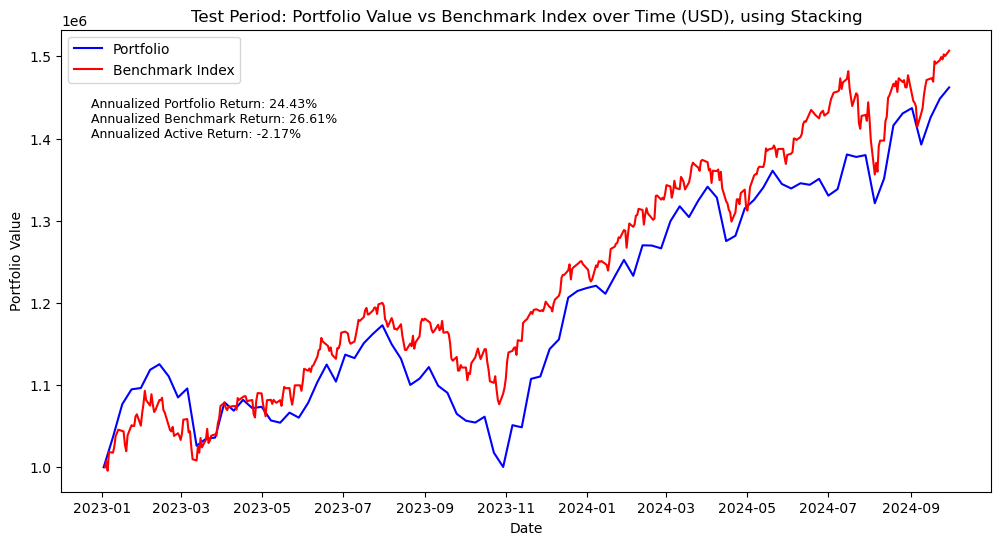

In [781]:
#plot both make big plot
plt.figure(figsize=(12,6))
plt.plot(portfolio_value, label="Portfolio", color="blue")
plt.plot(bm_index_prices_test_period.Date, bm_index_prices_test_period.Price, label="Benchmark Index", color="red")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plot_title = "Portfolio Value vs Benchmark Index over Time (USD)"
if eval_dataset_mode:
    plot_title = "Evaluation Period: " + plot_title
    plot_file_path = f"{DATA_DIR}/{BM_NAME}_plot_eval_{optimum_model_name}_port_vs_bm.png"
else:
    plot_title = "Test Period: " + plot_title
    plot_file_path = f"{DATA_DIR}/{BM_NAME}_plot_test_{optimum_model_name}_port_vs_bm.png"
plot_title += ", using " + optimum_model_name
plt.title(plot_title)
#print annualized port and bm and active returns, small font
plt.text(0.15, 0.75, f"Annualized Portfolio Return: {annualized_port_return:.2%}", fontsize=9, transform=plt.gcf().transFigure)
plt.text(0.15, 0.725, f"Annualized Benchmark Return: {annualized_bm_return:.2%}", fontsize=9, transform=plt.gcf().transFigure)
plt.text(0.15, 0.7, f"Annualized Active Return: {annualized_active_return:.2%}", fontsize=9, transform=plt.gcf().transFigure)
plt.legend(loc="upper left")
plt.savefig(plot_file_path)
plt.show()